<a href="https://colab.research.google.com/github/ucfilho/marquesgabi_mar_2020/blob/master/02_Mahotas_fracionado_B_mar_03_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install mahotas

In [0]:
# fotos pequenas 
# 02_Mahotas_fracionado_B_mar_03_2020.ipynb 
# fotos grandes
# 02_Mahotas_fracionado_A_mar_03_2020.ipynb

In [0]:
Escolha=['ASM', 'constrast', 'correl', 'variance', 'inv diff mom', 'sum aveg', 
         'sum var', 'sum entropy', 'entropy', 'dif var', 'dif entropy', 
         'IMC1', 'IMC2']
Prop=Escolha[1] # Propriedade a escolher para ter picos, largura de pico, proeminencia,...

In [0]:
!git clone https://github.com/ucfilho/marquesgabi_fev_2020 #clonar do Github
%cd marquesgabi_fev_2020

fatal: destination path 'marquesgabi_fev_2020' already exists and is not an empty directory.
/content/marquesgabi_fev_2020


In [0]:
import numpy as np
import cv2
from skimage import data
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from skimage import io, util
import mahotas.features.texture as mht
import mahotas.features
import os 
import zipfile
from skimage import filters
from skimage import exposure
import skimage.feature as sk
from google.colab import files
from numpy import linalg as LA
from scipy import stats
from scipy.signal import find_peaks
from scipy.signal import peak_prominences
from scipy.signal import peak_widths
from scipy import integrate
import re
import Go2BlackWhite
import Go2Mahotas
%matplotlib inline

In [0]:

Size=20 # tamanho da foto
Sub_Size=int(Size/5) # tamanho do fracionamento
Row_Crop=1/2 # posicao do corte
Crop=int(Size*Row_Crop)

In [0]:
Transfere='Fotos9Amostras.zip'
file_name = zipfile.ZipFile(Transfere, 'r')
file_name.extractall()

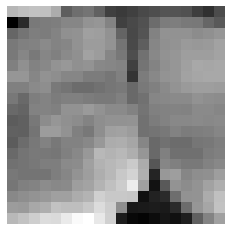

In [0]:
ww,img_name=Go2BlackWhite.BlackWhite(Transfere,Size)
plt.axis("off")
plt.imshow(ww[539], cmap = "gray")

In [0]:
NumFotos=len(img_name)

In [0]:
# Find the list elements starting with specific letter
subs = 'B'
Buraco = [x for x in img_name if re.search(subs, x)] 
subs = 'G'
Grao = [x for x in img_name if re.search(subs, x)] 
subs = 'I'
Indef = [x for x in img_name if re.search(subs, x)] 

In [0]:
# ESTA PARTE PRECISA PARA CALCULAR OS PICOS E AREA ABAIXO DA CURVA, CADA
# LINHA E UMA CURVA DA PROPRIEDADE ESCOLHIDA PARA UMA FOTO E CADA COLUNA 
# UM QUADRADO DA FOTO ANDANDO...
Todas_Fotos=[] 
# Todas_Fotos tem os valores medio da propriedade cada linha representa 
# uma foto e cada coluna as subdivisoes da foto (um quadrado que anda ao 
# longo da foto)
for k in range(NumFotos):
  Prop_Escolhida=[]
  #p_foto=ww[k,:].reshape(Size,Size)
  p_foto=ww[k].reshape(Size,Size)
  GLCM=[]
  glcm_haralick=[]
  x_ref=[]
  Count=Sub_Size
  p=np.zeros((Sub_Size,Sub_Size))
  j_ref=0
  Cada_foto=[]
  Posicao_X=[]
  Posicao_Y=[]
  for k in range(Size):
    if((k+Sub_Size-1)<Size):
      #print("(k+Sub_Size)=",(k+Sub_Size),"k=",k)
      for i in range(Sub_Size):
        Posicao_X.append(Crop+i)
        for j in range(Sub_Size):
          p[i,j]=p_foto[Crop+i,j+k]
          Posicao_Y.append(j+k)

      WW=np.copy(p) 
      Cada_foto.append(WW.ravel())
      x_ref.append(Count-Sub_Size)
      Count=Count+1
     
      Mahotas =pd.DataFrame(mahotas.features.haralick(p.astype(int)), columns =Escolha)
      Prop_Escolhida.append(Mahotas[Prop].mean())

  Todas_Fotos.append(Prop_Escolhida)

df=pd.DataFrame(Todas_Fotos)



In [0]:
print(df)

              0            1           2   ...           14           15          16
0      15.805556    59.854167   90.243056  ...    22.236111   221.625000  263.694444
1     334.513889   166.770833   21.409722  ...   160.145833   162.298611  266.145833
2      36.465278    73.875000  118.305556  ...   169.034722   264.666667  309.222222
3      77.875000   403.062500  868.902778  ...    32.930556   123.861111  439.076389
4      30.006944    13.534722   20.555556  ...   343.784722   177.465278  235.729167
..           ...          ...         ...  ...          ...          ...         ...
535   632.069444   513.083333  294.055556  ...   144.708333   129.006944  148.722222
536  1858.451389  1918.118056  810.284722  ...  2254.291667  1501.819444  774.548611
537    57.263889    80.770833   87.458333  ...    19.097222    23.743056   37.451389
538    69.125000    89.659722  107.888889  ...    11.131944    15.027778   16.284722
539    68.451389    84.868056   80.138889  ...    29.826389    23

In [0]:
print(len(Cada_foto[0])) # Cada_foto contem a foto pequena varrida
print(np.array(Cada_foto).shape)

16
(17, 16)


In [0]:
print(NumFotos)

540


In [0]:
# esta parte calcula picos, area abaixo da curva antes ela precisa gerar 
# o dataframe que contem a propriedade escolhida com uma foto em cada linha ....
Features_Total=[]
for i in range(NumFotos):
  x=df.iloc[i]
  peaks, rr = find_peaks(x, height=0)

  N_peaks=len(peaks)
  prominences = peak_prominences(x, peaks)
  
  #Area = simps(x, dx=1)
  Area = integrate.simps(x, dx=1)
  if(len(peaks)==0):
    Width_peaks =0
    Width_peaks_max =0
    Width_peaks_min =0
    Media_proem=0    
  else:
    Width_peaks =np.mean(peak_widths(x, peaks, rel_height=0.5))
    Width_peaks_max =np.max(peak_widths(x, peaks, rel_height=0.5))
    Width_peaks_min =np.min(peak_widths(x, peaks, rel_height=0.5))
    Media_proem=np.mean(prominences)
  Median = np.median(x)
  Mode= stats.mode(x)[0]
  Mean=np.mean(x)
  Sd=np.std(x)

  Features=[]
  Features.append(N_peaks)
  Features.append(Media_proem )
  Features.append(Area)
  Features.append(Width_peaks )
  Features.append(Width_peaks_max)
  Features.append(Width_peaks_min)
  Features.append(Median )
  Features.append(Mode[0])
  Features.append(Mean)
  Features.append(Sd)

  Features_Total.append(Features)

Nomes_Fracionada=['N_peaks','Media_proem','Area','Width_peaks','Width_peaks_max',
                    'Width_peaks_min','Median','Mode','Mean','Sd'] 
  
Features_Total=pd.DataFrame(Features_Total,columns=Nomes_Fracionada)


In [0]:
print(Features_Total)

     N_peaks  Media_proem          Area  ...       Mode        Mean          Sd
0          2    21.739583   1024.861111  ...  15.805556   66.996324   68.468751
1          1    13.347222   1140.793981  ...  10.854167   86.345997   95.539228
2          2    50.770833   2055.159722  ...  30.750000  130.039216   85.504751
3          2   196.148148   4612.201389  ...  13.152778  285.037990  368.875344
4          2   248.665509   5680.388889  ...  13.534722  347.037582  297.346788
..       ...          ...           ...  ...        ...         ...         ...
535        2     9.608796   1926.587963  ...  15.861111  137.834150  175.397843
536        2   330.730324  15839.675926  ...  40.881944  995.582925  883.242231
537        2    54.449074   1677.807870  ...   9.791667  104.133170   95.560662
538        2    14.743056    662.655093  ...   6.437500   41.932190   35.139916
539        3    19.560957   1105.097222  ...  17.006944   66.435049   33.177403

[540 rows x 10 columns]


In [0]:
# found drive
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:
print(Features_Total.iloc[92])


N_peaks               3.000000
Media_proem          18.106481
Area               1183.581019
Width_peaks          23.146897
Width_peaks_max     109.069444
Width_peaks_min       0.654638
Median               66.784722
Mode                 29.250000
Mean                 73.074346
Sd                   35.952348
Name: 92, dtype: float64


In [0]:

print(Features_Total.iloc[520])

N_peaks                1.000000
Media_proem          373.895833
Area               10156.000000
Width_peaks          361.402484
Width_peaks_max     1414.920139
Width_peaks_min        2.304858
Median               220.895833
Mode                  97.694444
Mean                 721.428513
Sd                   849.161543
Name: 520, dtype: float64


In [0]:
# get csv file
#Features_Total.to_csv('Contraste_Fracionado_fev_2020.csv')
# a mundaca do formato  float_format="%.5f"   objetiva 
# evitar corromper alguns pontos como aconteceu 
# antes desta mudanca mudar 
Features_Total.to_csv('Contraste_Fracionado_B_mar_2020.csv', float_format="%.5f")

In [0]:
# save in drive
!cp Contraste_Fracionado_B_mar_2020.csv drive/My\ Drive/Maria_Gabriela_Textura_dados_jan_2020/